# Facial Morphing - StyleGan2 approach

### Requirements
- Create a Kaggle account
- Ensure you have verified your account with email **AND** phone (This enables the use of internet and GPU)
### Project Setup
- With your account now verified, expand the Session options in the right sidebar
    - 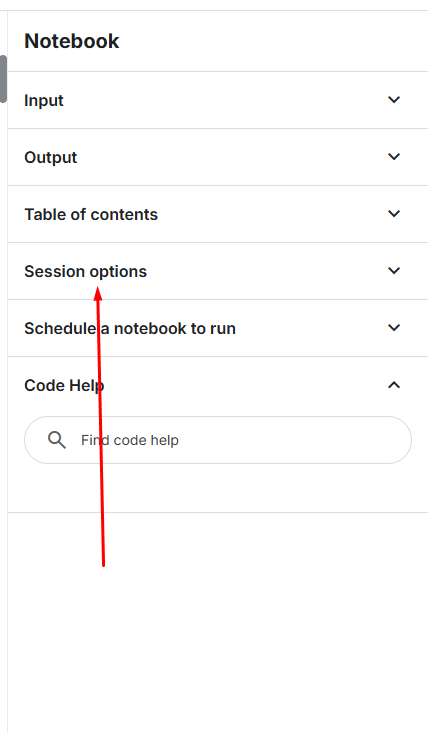
- Under the dropdown for `Accelerator` select `GPU P100`
- Under the heading `Internet` ensure the switch is turned on.

### Uploading the faces to morph
- In the sidebar under `Input` select `Upload`
- Upload your files as a zip. Each folder in the zip will be considered a new morph. Each image in the folders will be morphed.
- In the second code block, change the `input_root` variable to the name of your new dataset
- Run the code
- Download the `output_images.zip` file
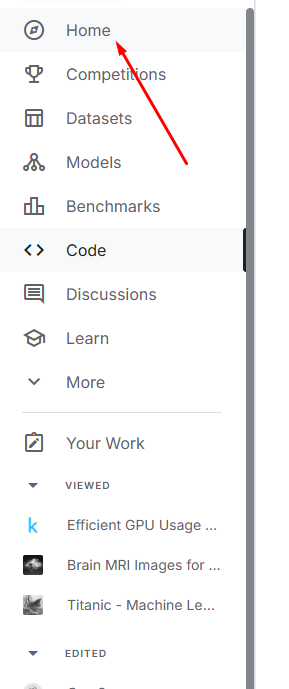
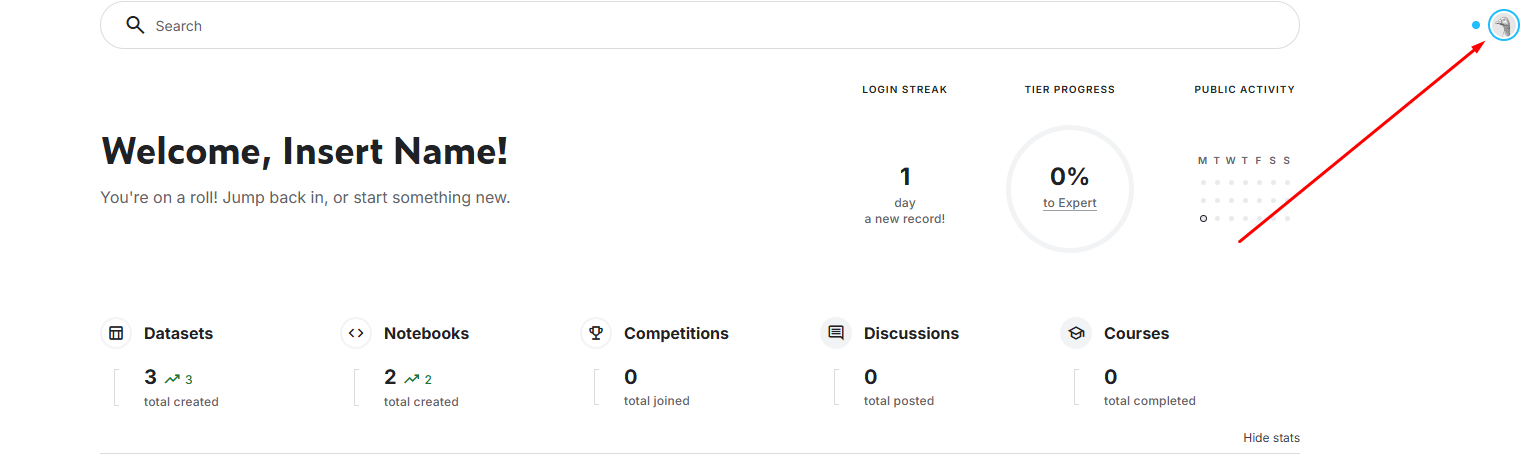
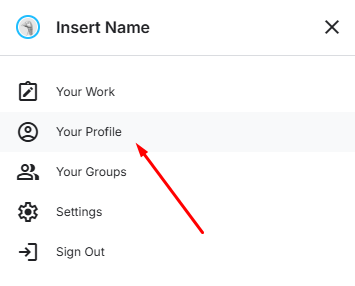
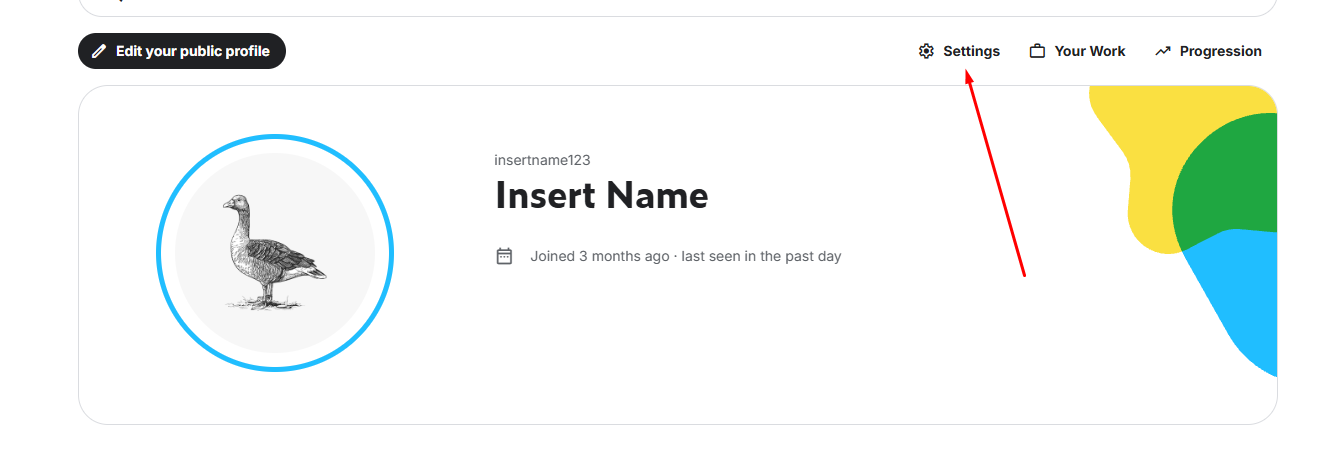
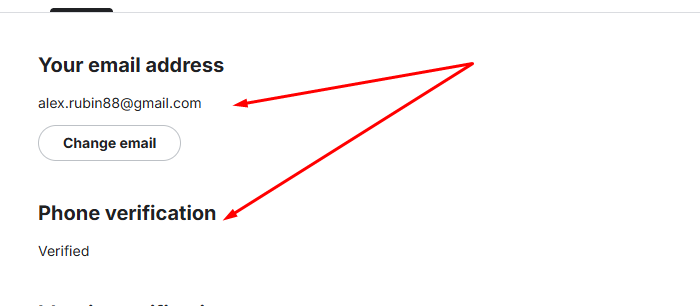

Near Perfect replications:

In [1]:
# ===============================================================
# PTI set-up and run_PTI() on every image in your dataset
# ===============================================================
import os
os.environ["TQDM_DISABLE"] = "1"
import sys, subprocess, shutil, torch
from pathlib import Path
os.chdir('/kaggle/working')

# ---------- clone repo ---------------------------------------------------
if not Path('PTI').is_dir():
    subprocess.run(['git','clone','-q','https://github.com/danielroich/PTI.git'])
sys.path.append('./PTI')

# ---------- install Python deps -----------------------------------------
%cd PTI
!pip install -q wandb lpips gdown
%cd ..

# ---------- speed-up StyleGAN -------------------------------------------
!wget -q https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip -o ninja-linux.zip -d /usr/local/bin/ && sudo chmod +x /usr/local/bin/ninja

# ---------- download checkpoints (all with gdown) -----------------------
PRE_DIR = Path('PTI/pretrained_models'); PRE_DIR.mkdir(exist_ok=True)

!gdown 1M-hsL3W_cJKs77xM1mwq2e9-J0_m7rHP -O PTI/pretrained_models/e4e_ffhq_encode.pt   # e4e
!gdown 125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M  -O PTI/pretrained_models/ffhq.pkl            # StyleGAN-2 FFHQ
!gdown 1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR -O PTI/pretrained_models/align.dat            # dlib align

print('✅  repos, packages and weights ready')
# Add PTI to path
%cd /kaggle/working/PTI
sys.path.insert(0, '/kaggle/working/PTI')

/kaggle/working/PTI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00:00:0100:01
/kaggle

In [1]:
# ===============================================================
#  RUN PTI ON A SINGLE IMAGE
# ===============================================================
import sys
import shutil
import torch
import pickle
from pathlib import Path

# Add PTI to path
%cd /kaggle/working/PTI
sys.path.insert(0, '/kaggle/working/PTI')

# Import PTI modules
from configs import paths_config, global_config, hyperparameters
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from utils.data_utils import tensor2im

def load_generators(model_id, image_name):
    with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
        old_G = pickle.load(f)['G_ema'].cuda()
    
    with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new: 
        new_G = torch.load(f_new, weights_only=False).cuda()
    
    return old_G, new_G

# Setup paths
DATA_ROOT = Path('/kaggle/input/my-face-images2')
PTI_ROOT = Path('/kaggle/working/PTI')
OUT_ROOT = PTI_ROOT/'outputs_pti'
OUT_ROOT.mkdir(exist_ok=True)

# Configure PTI
DLIB_PATH = '/kaggle/working/PTI/pretrained_models/align.dat'
paths_config.dlib = DLIB_PATH
global_config.device = 'cuda'

# # Cache the StyleGAN2 model
# print("🔄 Loading StyleGAN2 model...")
# cached_G = models_utils_module.load_old_G()
# print("✅ Model loaded and cached")

# Find the first image to process
img_count = 0
img_path = None

for folder in sorted(DATA_ROOT.iterdir()):
    if not folder.is_dir(): 
        continue
    for potential_img in sorted([p for p in folder.iterdir() if p.suffix.lower() in ('.jpg','.png','.jpeg')]):
        if img_count == 0:  # Skip first (0), take second (1)
            img_path = potential_img
            folder_name = folder.name
            break
        img_count += 1
    if img_path:
        break

if not img_path:
    print("❌ No image found in the dataset!")
    exit()

print(f"📸 Processing image: {img_path}")

# Setup working directories for this image
img_id = f'{folder_name}_{img_path.stem}'
work_dir = PTI_ROOT/f'{img_id}_tmp'
raw = work_dir/'raw'
proc = work_dir/'processed'

# Create directories
proc.mkdir(parents=True, exist_ok=True)
raw.mkdir(parents=True, exist_ok=True)

# Copy image to working directory
shutil.copy(img_path, raw/f'{img_id}.jpg')

# Configure PTI paths
paths_config.input_data_id = img_id
paths_config.input_data_path = proc.as_posix()
paths_config.checkpoints_dir = OUT_ROOT.as_posix()
paths_config.style_clip_pretrained_mappers = '/kaggle/working/PTI/pretrained_models'
paths_config.stylegan2_ada_ffhq = '/kaggle/working/PTI/pretrained_models/ffhq.pkl'
paths_config.e4e = '/kaggle/working/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.checkpoints_dir = '/kaggle/working/PTI/checkpoints'
paths_config.embedding_base_dir = '/kaggle/working/PTI/embeddings'
paths_config.styleclip_output_dir = '/kaggle/working/PTI/StyleCLIP_results'
paths_config.experiments_output_dir = '/kaggle/working/PTI/output'
# Set hyperparameters
hyperparameters.use_locality_regularization = False
hyperparameters.max_pti_steps = 350

# Preprocess the image (alignment)
print("🔄 Preprocessing image (alignment)...")
# Import and use the preprocessing function
from utils.align_data import pre_process_images
pre_process_images(raw.as_posix())

# Run PTI
print(f'🔄 Running PTI for {img_id}')
from scripts.run_pti import run_PTI
model_id = run_PTI(use_wandb=False, use_multi_id_training=False)

print(f'✅ PTI completed! Model ID: {model_id}')

# ===============================================================
# GENERATE IMAGE FROM PTI RESULT
# ===============================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_output = Path('single_image_output')
final_output.mkdir(exist_ok=True)

# Use the actual model_id and img_id from the PTI run
print(f"Loading generators with model_id: {model_id}, image_name: {img_id}")

# Load the generators
old_G, new_G = load_generators(model_id, img_id)
    
# Try to find and load the pivot latent
pivot_file = f'{paths_config.embedding_base_dir}/{img_id}/PTI/{img_id}/0.pt'
    
latent = None
if Path(pivot_file).exists():
    print(f"Found pivot file: {pivot_file}")
    latent = torch.load(pivot_file, map_location=device, weights_only=False)
    print(f"Loaded object type: {type(latent)}")
    print(f"Latent shape: {latent.shape}")
    print(f"Latent device: {latent.device}")
    
if latent is None:
    print("⚠️ No pivot file found, using random latent")
    latent = torch.randn(1, 18, 512).to(device)

c = None
if new_G.c_dim > 0:
    c = torch.zeros(1, new_G.c_dim, device=device) # or any appropriate label tensor
# Generate image with the optimized generator
with torch.no_grad():
    img = new_G.synthesis(latent, noise_mode='const', force_fp32 = True)[0]
    #img = new_G(latent, c=c)[0]
    
# Convert and save
img_pil = tensor2im(img.cpu())
save_path = final_output / f'{img_id}_reconstructed.jpg'
img_pil.save(save_path)
print(f'✅ Reconstructed image saved to {save_path}')
    

print('🎉 Single image PTI processing complete!')

/kaggle/working/PTI
📸 Processing image: /kaggle/input/my-face-images2/Asian_Test/FPM_115_G5_6 no lights_cc.png
🔄 Preprocessing image (alignment)...


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄 Running PTI for Asian_Test_FPM_115_G5_6 no lights_cc
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.



  0%|          | 0/450 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.



  0%|          | 0/1 [01:09<?, ?it/s]


KeyboardInterrupt: 

In [20]:
import os, sys, time, shutil, zipfile, tempfile, traceback, itertools
from pathlib import Path
import torch
import gradio as gr

# ==== PTI imports ====
PTI_ROOT = Path('/kaggle/working/PTI')  # adjust if needed
sys.path.insert(0, str(PTI_ROOT))

from configs import paths_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from utils.data_utils import tensor2im
import pickle

# Set paths (adjust if your setup differs)
paths_config.style_clip_pretrained_mappers = str(PTI_ROOT / 'pretrained_models')
paths_config.stylegan2_ada_ffhq = str(PTI_ROOT / 'pretrained_models' / 'ffhq.pkl')
paths_config.e4e = str(PTI_ROOT / 'pretrained_models' / 'e4e_ffhq_encode.pt')
paths_config.checkpoints_dir = str(PTI_ROOT / 'checkpoints')
paths_config.embedding_base_dir = str(PTI_ROOT / 'embeddings')
paths_config.styleclip_output_dir = str(PTI_ROOT / 'StyleCLIP_results')
paths_config.experiments_output_dir = str(PTI_ROOT / 'output')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==== Helpers ====
def load_generators(model_id, image_name):
    with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
        old_G = pickle.load(f)['G_ema'].to(device)
    with open(f"{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt", 'rb') as f_new:
        new_G = torch.load(f_new, map_location=device, weights_only=False)
    return old_G, new_G

def load_latent(img_id):
    pivot_path = PTI_ROOT / f'embeddings/{img_id}/PTI/{img_id}/0.pt'
    if not pivot_path.exists():
        return None
    return torch.load(pivot_path, map_location=device)

def run_pti_on_image(img_path, folder_name):
    img_id = f'{folder_name}_{img_path.stem}'
    work_dir = PTI_ROOT / f'{img_id}_tmp'
    raw, proc = work_dir / 'raw', work_dir / 'processed'
    raw.mkdir(parents=True, exist_ok=True)
    proc.mkdir(parents=True, exist_ok=True)
    shutil.copy(img_path, raw / f'{img_id}.jpg')

    paths_config.input_data_id = img_id
    paths_config.input_data_path = proc.as_posix()

    pre_process_images(raw.as_posix())
    model_id = run_PTI(use_wandb=False, use_multi_id_training=False)
    return img_id, model_id

# ==== Streaming processor ====
def process_zip_stream(zip_file_path):
    logs = []

    def push(msg, file=None):
        logs.append(msg)
        yield file, "\n".join(logs)

    try:
        work_root = Path(tempfile.mkdtemp(prefix="pti_zip_"))
        extract_root = work_root / "input"
        output_root = work_root / "output_images"
        extract_root.mkdir(parents=True, exist_ok=True)
        output_root.mkdir(parents=True, exist_ok=True)

        yield from push("📦 Extracting input zip...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_root)
        yield from push("✅ Extracted.")

        # process folders
        exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.webp"]

        for folder in sorted(extract_root.iterdir()):
            if not folder.is_dir():
                continue
            yield from push(f"\n📂 Processing folder: {folder.name}")

            imgs = sorted(itertools.chain.from_iterable(folder.glob(ext) for ext in exts))
            if not imgs:
                yield from push(f"⚠️ No images in {folder.name}, skipping.")
                continue

            latents = []
            last_img_id, last_model_id = None, None

            for img_path in imgs:
                start = time.time()
                yield from push(f"🔄 PTI on {img_path.name} ...")
                img_id, model_id = run_pti_on_image(img_path, folder.name)
                latent = load_latent(img_id)
                if latent is not None:
                    latents.append(latent.to(device))
                elapsed = time.time() - start
                yield from push(f"✅ Done {img_path.name} ({elapsed:.2f}s)")
                last_img_id, last_model_id = img_id, model_id

            if not latents:
                yield from push(f"⚠️ No valid latents for {folder.name}, skipping blend.")
                continue

            yield from push(f"➕ Averaging {len(latents)} latents...")
            avg_latent = torch.mean(torch.cat(latents, dim=0), dim=0, keepdim=True)

            old_G, new_G = load_generators(last_model_id, last_img_id)
            new_G.eval()
            with torch.no_grad():
                img = new_G.synthesis(avg_latent, noise_mode='random', force_fp32=True)[0]
            img_pil = tensor2im(img.cpu())

            output_folder = output_root / folder.name
            output_folder.mkdir(parents=True, exist_ok=True)
            save_path = output_folder / "Morph.png"
            img_pil.save(save_path, compress_level=6)
            yield from push(f"🖼️ Saved {save_path}")

        yield from push("🧰 Zipping outputs...")
        zip_out_path = work_root / "output_images.zip"
        with zipfile.ZipFile(zip_out_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for file_path in output_root.rglob('*'):
                if file_path.is_file():
                    zipf.write(file_path, file_path.relative_to(output_root))

        yield str(zip_out_path), "\n".join(logs)

    except Exception:
        tb = traceback.format_exc()
        yield None, f"❌ Error occurred:\n{tb}"

# ==== Gradio UI ====
with gr.Blocks(title="PTI Folder-Blend (Zip ➜ Zip)") as demo:
    gr.Markdown("## PTI Folder-Blend (Zip ➜ Zip)")
    with gr.Row():
        zip_in = gr.File(label="Upload .zip (folders with images)", file_count="single", type="filepath")
    with gr.Row():
        run_btn = gr.Button("Run PTI Blends", variant="primary")
    with gr.Row():
        zip_out = gr.File(label="Download output_images.zip")
    logs_box = gr.Textbox(label="Logs", lines=20)

    # Connect button directly to generator
    run_btn.click(
        fn=process_zip_stream,
        inputs=[zip_in],
        outputs=[zip_out, logs_box],
    )

demo.queue().launch(share=True)


* Running on local URL:  http://127.0.0.1:7873
* Running on public URL: https://94b9fc930acc9278e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


 10%|▉         | 44/450 [00:06<00:56,  7.21it/s]